# 8.2 Scenario analyses with intervals

In this tutorial we will work through an example where we create 'credible intervals'. We will return to the example from tutorial 5.2 where we assessed a vaccine for SIR, but this time we will incorporate some of the stochasticity that we saw in tutorial 5.5. We will also illustrate how you can add demographics to your model.

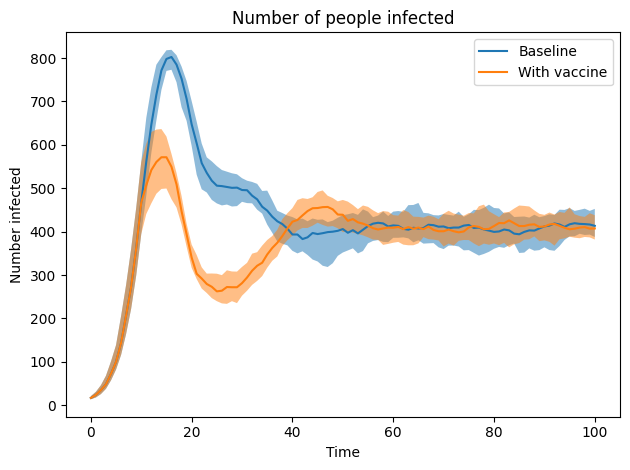

In [8]:
import numpy as np # Math
import sciris as sc # Utilities
import pylab as pl # Plotting
import starsim as ss # ABM


class Vaccine(ss.Intervention):
    def __init__(self, timestep=10, prob=0.5, imm_boost=2.0):
        super().__init__() # Initialize the intervention
        self.timestep = timestep # Store the timestep the vaccine is applied on
        self.prob = prob # Store the probability of vaccination
        self.imm_boost = imm_boost # Store the amount by which immunity is boosted

    def apply(self, sim): # Apply the vaccine
        if sim.ti == self.timestep: # Only apply on the matching timestep
            sis = sim.diseases.sis # Shorten the name of the disease module
            eligible_ids = sim.people.uid[sis.susceptible] # Only susceptible people are eligible
            n_eligible = len(eligible_ids)  # Number of people who are eligible
            to_vaccinate = self.prob > np.random.rand(n_eligible) # Define which of the n_eligible people get vaccinated
            vaccine_ids = eligible_ids[to_vaccinate]
            sis.immunity[vaccine_ids] += self.imm_boost


def make_run_sim(n_timesteps=100, seed=1, use_vaccine=False, timestep=10, prob=0.5, imm_boost=2.0):

    pars = dict(
        n_agents = 1000,
        start = 0,
        end = n_timesteps,
        dt = 1.0,
        verbose = 0,
        rand_seed = seed,
        networks = 'random',
        diseases = dict(
            type = 'sis',
            beta = 0.05,
            waning = 0.05,
        )
    )

    # Define "baseline" and "intervention" sims without and with the vaccine
    if use_vaccine:
        vaccine = Vaccine(timestep=timestep, prob=prob, imm_boost=imm_boost)
        sim = ss.Sim(pars, interventions=vaccine)
    else:
        sim = ss.Sim(pars)

    # Run the simulation
    sim.run()
    results = sc.objdict()
    results.seed = seed
    results.time = sim.yearvec
    results.n_infected = sim.results.sis.n_infected
    return results

# Prepare to run multiple times
n_seeds = 20  # Don't use too many here or your sim will take a very long time!
n_timesteps = 100  # Again, don't use too many
baseline_results = np.empty((n_seeds, n_timesteps+1))  # Initialise storage of baseline results
vaccine_results = np.empty((n_seeds, n_timesteps+1))  # Initialise storage of vaccine results
difference_results = np.empty(n_seeds)    # Initialise storage of differences - this will tell us the impact

# Make and run the simulation with different seeds
for seed in range(n_seeds): # Run over 5 different random seeds
    results = make_run_sim(seed=seed) # Run the simulation with no vaccine
    baseline_results[seed, :] = results.n_infected  # Pull out results from baseline
    results = make_run_sim(seed=seed, use_vaccine=True) # Run the simulation with the vaccine
    vaccine_results[seed, :] = results.n_infected  # Pull out results from vaccine scenarios
    difference_results[seed] = baseline_results[seed, :].sum() - vaccine_results[seed, :].sum()  # Calculate differences


# Get the qunatile for plotting
lower_bound_baseline = np.quantile(baseline_results, 0.05, axis=0)
median_baseline = np.quantile(baseline_results, 0.5, axis=0)
upper_bound_baseline = np.quantile(baseline_results, 0.95, axis=0)
lower_bound_vaccine = np.quantile(vaccine_results, 0.05, axis=0)
median_vaccine = np.quantile(vaccine_results, 0.5, axis=0)
upper_bound_vaccine = np.quantile(vaccine_results, 0.95, axis=0)

# Start plotting
pl.figure()  # Create the figure
pl.title('Number of people infected')
pl.fill_between(results.time, lower_bound_baseline, upper_bound_baseline, alpha=0.5)
pl.plot(results.time, median_baseline, label='Baseline')
pl.fill_between(results.time, lower_bound_vaccine, upper_bound_vaccine, alpha=0.5)
pl.plot(results.time, median_vaccine, label='With vaccine')
pl.xlabel('Time')
pl.ylabel('Number infected')
pl.legend()
sc.figlayout()
pl.show()

# Print differences
lower_bound_difference = np.quantile(difference_results, 0.05)
upper_bound_difference = np.quantile(difference_results, 0.95)
median_difference = np.quantile(difference_results, 0.5)
print(f'Estimated difference: {median_difference:.0f} [{lower_bound_difference:.0f}, {upper_bound_difference:.0f}]')





## Problem 2

For our SIS model, it is not known whether or not people with prior immunity are less transmissible. The government need to decide vaccination advice for people with a prior history of infection. The scale of impact will depend on how transmissible these people are. They have asked to see some ranges.


Initializing sim with 10000 agents
  Running "Sim with imm_boost=0.0": 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running "Sim with imm_boost=0.0": 10.0 (10/31) (0.41 s)  •••••••————————————— 35%
  Running "Sim with imm_boost=0.0": 20.0 (20/31) (0.56 s)  •••••••••••••——————— 68%
  Running "Sim with imm_boost=0.0": 30.0 (30/31) (0.75 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running "Sim with imm_boost=0.2": 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running "Sim with imm_boost=0.2": 10.0 (10/31) (0.56 s)  •••••••————————————— 35%
  Running "Sim with imm_boost=0.2": 20.0 (20/31) (0.82 s)  •••••••••••••——————— 68%
  Running "Sim with imm_boost=0.2": 30.0 (30/31) (1.56 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running "Sim with imm_boost=0.4": 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running "Sim with imm_boost=0.4": 10.0 (10/31) (0.27 s)  •••••••————————————— 35%
  Running "Sim with imm_boost=0.4": 20.0 (20/31) (0.56 s)

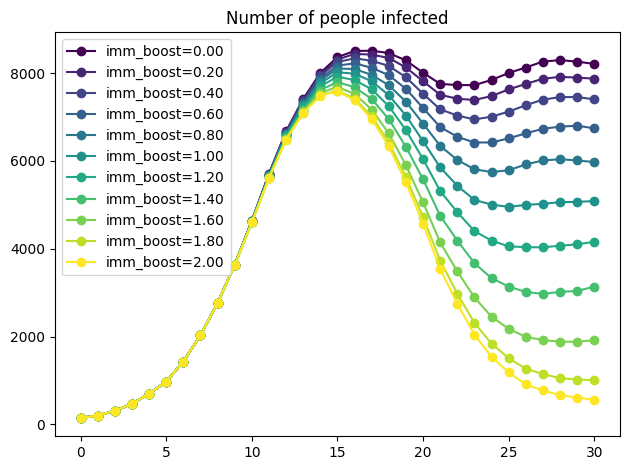

In [16]:
def make_run_sim(lower_imm_boost=0, upper_imm_boost=2, n_steps=11):

    # Make an array with different levels of immunie boosting
    imm_boost_array = np.linspace(lower_imm_boost, upper_imm_boost, n_steps)

    # Make the sim parameters
    pars = dict(start=0, end=30, dt=1.0, networks='random')  # Define the parameters of the simulation

    # Prepare a dictionary to store the results
    results = dict()

    # Set the per-contact transmission probability
    sis_beta = 0.05

    # Loop over different immunity parameters 
    for imm_boost in imm_boost_array:
        sis = ss.SIS(pars=dict(beta=sis_beta, imm_boost=imm_boost))  # Create an instance of the SIS disease with the particular imm_boost parameter
        sim = ss.Sim(pars=pars, diseases=sis, label=f'Sim with imm_boost={imm_boost}')  # Create the sim
        sim.run()  # Run the sim

        # Pull out results
        tvec = sim.yearvec
        n_inf = sim.results.sis.n_infected
        results[imm_boost] = n_inf  # Store results in a dictionary

    # Prepare to plot
    colors = sc.vectocolor(imm_boost_array)  # Create a continuous array of colors

    # Prepare a figure to plot all the results together
    pl.figure()
    pl.subplot(1,1,1) 

    # Loop over different immunity parameters and plot each one on the same figure
    for i,imm_boost in enumerate(imm_boost_array):
        pl.plot(tvec, results[imm_boost], 'o-', color=colors[i], label=f'imm_boost={imm_boost:.2f}')  # Plot with evolution

    # Add title and legend, format figure, and display results
    pl.title('Number of people infected')
    pl.legend()
    sc.figlayout()
    pl.show()



# Make, run, and plot the simulation
make_run_sim()